In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('ggplot')

from random import seed
from random import random
from sklearn.linear_model import LogisticRegression

import importlib
import SOAMtg24_models as mdls
importlib.reload(mdls)


<module 'SOAMtg24_models' from '/Users/joehaber/Desktop/Desktop/1. ActuariAI/Research/OWL_Nadav/SOAMtg24_models.py'>

### Get Data

In [2]:
df = pd.read_csv('Readmit_R.csv')

In [3]:
# Clean up

df.drop(columns=df.columns[0:1], axis=1, inplace=True)

df.rename({'ID.Codes': 'ID', 
           'Readmission.Status': 'Readmit', 
           'DRG.Class': 'DRG_Class', 
           'DRG.Complication': 'DRG_Comp',
           'HCC.Riskscore': 'HCC'}, axis=1, inplace=True)

In [4]:
print(df.shape)
df.head()

(66782, 10)


,ID,Readmit,Gender,Race,ER,DRG_Class,LOS,Age,HCC,DRG_Comp
0,0005EC02F1DC3A15,0,M,White,0,MED,3,71,1.631,MedicalMCC.CC
1,0005EC02F1DC3A15,0,M,White,0,SURG,2,71,1.631,Other
2,0006C4369B0D7B5F,0,M,White,0,MED,2,68,0.585,MedicalNoC
3,000960C9E1C43BE4,0,F,White,0,SURG,12,79,1.660,SurgNoC
4,00098CF15837D918,0,M,White,0,SURG,4,91,1.768,SurgNoC


In [5]:
df.Readmit.value_counts()

Readmit
0    58373
1     8409
Name: count, dtype: int64

In [6]:
df1 = pd.get_dummies(df, columns = ['Gender','Race','DRG_Class','DRG_Comp'], drop_first=True)

In [7]:
df1.head()

,ID,Readmit,ER,LOS,Age,HCC,Gender_M,Race_Hispanic,Race_Others,Race_White,DRG_Class_SURG,DRG_Class_UNGROUP,DRG_Comp_MedicalNoC,DRG_Comp_Other,DRG_Comp_SurgMCC.CC,DRG_Comp_SurgNoC
0,0005EC02F1DC3A15,0,0,3,71,1.631,True,False,False,True,False,False,False,False,False,False
1,0005EC02F1DC3A15,0,0,2,71,1.631,True,False,False,True,True,False,False,True,False,False
2,0006C4369B0D7B5F,0,0,2,68,0.585,True,False,False,True,False,False,True,False,False,False
3,000960C9E1C43BE4,0,0,12,79,1.660,False,False,False,True,True,False,False,False,False,True
4,00098CF15837D918,0,0,4,91,1.768,True,False,False,True,True,False,False,False,False,True


### Create Subgroups (via risk propensities)

In [8]:
df1 = mdls.create_subgroups(df1)

In [9]:
df1.groupby('subgroup')['preds'].mean()

subgroup
0    0.071706
1    0.130614
2    0.283908
Name: preds, dtype: float64

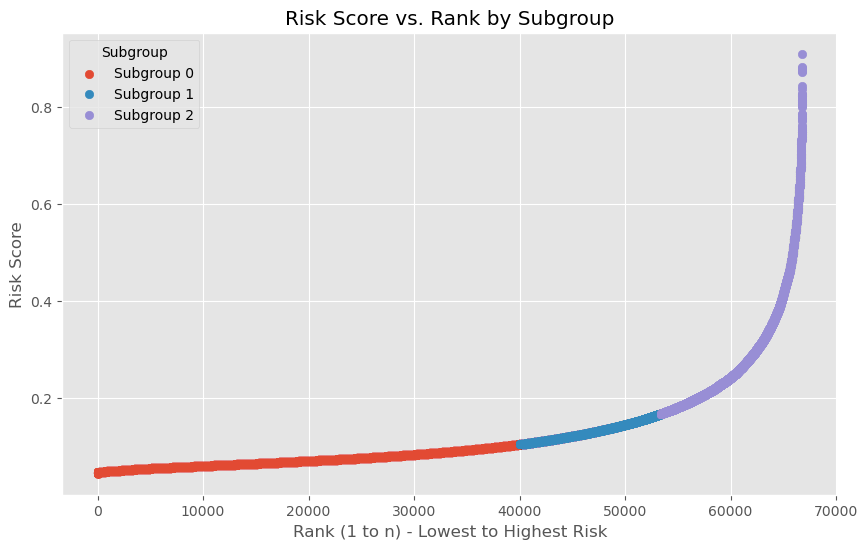

In [10]:
# Sort the DataFrame by 'preds' to get the ranks
df_sorted = df1.sort_values(by='preds').reset_index(drop=True)

# Create a rank for x-axis
df_sorted['rank'] = df_sorted.index + 1

# Plotting
plt.figure(figsize=(10, 6))

# Loop through each unique subgroup and plot with a different color
for subgroup in df_sorted['subgroup'].unique():
    subgroup_data = df_sorted[df_sorted['subgroup'] == subgroup]
    plt.scatter(subgroup_data['rank'], subgroup_data['preds'], label=f'Subgroup {subgroup}')

plt.xlabel('Rank (1 to n) - Lowest to Highest Risk')
plt.ylabel('Risk Score')
plt.title('Risk Score vs. Rank by Subgroup')
plt.grid(True)
plt.legend(title='Subgroup')
plt.show()

### Create Treatment

In [11]:
# seed random number generator
seed(1)
# Randomized Tx (30% of cohort)
df1['Tx'] = [1 if np.random.rand()<0.3 else 0 for k in df1.index]

In [12]:
df1 = mdls.create_treatment1(df1)

In [13]:
exp_results_df = df1.groupby('Tx')[['Readmit','Readmit_red']].mean() #actual
exp_results_df

,Readmit,Readmit_red
Tx,,
0,0.125117,0.125117
1,0.127802,0.064780


In [14]:
df1.head()

,ID,Readmit,ER,LOS,Age,HCC,Gender_M,Race_Hispanic,Race_Others,Race_White,DRG_Class_SURG,DRG_Class_UNGROUP,DRG_Comp_MedicalNoC,DRG_Comp_Other,DRG_Comp_SurgMCC.CC,DRG_Comp_SurgNoC,preds,subgroup,Tx,Readmit_red
0,0005EC02F1DC3A15,0,0,3,71,1.631,True,False,False,True,False,False,False,False,False,False,0.079367,0,0,0
1,0005EC02F1DC3A15,0,0,2,71,1.631,True,False,False,True,True,False,False,True,False,False,0.085171,0,1,0
2,0006C4369B0D7B5F,0,0,2,68,0.585,True,False,False,True,False,False,True,False,False,False,0.051437,0,0,0
3,000960C9E1C43BE4,0,0,12,79,1.660,False,False,False,True,True,False,False,False,False,True,0.083321,0,0,0
4,00098CF15837D918,0,0,4,91,1.768,True,False,False,True,True,False,False,False,False,True,0.076499,0,0,0


### Create Cost

In [15]:
df1 = mdls.create_cost(df1, 'Tx', c0=10, c1=400)

In [16]:
df1.groupby('Tx').agg(
    count=('ID', 'size'),
    avg_cost=('cost', 'mean')
).reset_index()

,Tx,count,avg_cost
0,0,46884,10.0
1,1,19898,400.0


### OWL Model

In [17]:
features_df = df1.drop(['Readmit','Readmit_red','ID','preds','subgroup'],axis=1)

A = df1.columns.to_list()
B = ['Readmit','Readmit_red','ID','preds','subgroup','Tx']
features = list(set(A) - set(B)) 

In [18]:
from sklearn.model_selection import train_test_split

train_index, test_index = train_test_split(df1.index, test_size=0.3, random_state=0)
    
train_df = df1.iloc[train_index]
test_df  = df1.iloc[test_index]

In [19]:
k_values = np.arange(0.1, 1.1, 0.1)
svm_C = 1.0  # You can adjust this value
results_df = mdls.analyze_k_values(train_df, test_df, features, 'Tx', 'cost', 'Readmit_red', k_values, svm_C)
print(results_df)

Starting train_owl_svm with k=0.1, SVM C=1.0
transformed risk Tx: 24.120573964933683
transformed risk ~Tx: 11.103241351019882
cost Tx: 400.0
cost ~Tx: 10.0
weight Tx: 0.006173162498184535
weight ~Tx: 0.15832319680126436
                     ID  Readmit  ER  LOS  Age    HCC  Gender_M  \
32380  7BE731D4BBF4F80C        0   0    6   73  2.392     False   
31166  77200681F8836F2E        0   1    6   70  1.038     False   
10877  2A1E3B0A53D6A56F        0   1    4   77  0.552     False   
10322  27F6C86F22CD1FD0        0   0    1   85  1.018      True   
22199  559FB4D58DF725B7        0   0    4   82  2.369      True   

       Race_Hispanic  Race_Others  Race_White  DRG_Class_SURG  \
32380          False        False        True            True   
31166          False         True       False            True   
10877          False        False       False            True   
10322          False        False        True            True   
22199          False        False        True       